In [1]:
import os
import tempfile
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.python.keras import Input
from tensorflow.python.keras.engine.training import Model
from tensorflow.python.keras.layers import GaussianNoise, Dense, Dropout

from util.annotation_reader import import_training
from util.config_manager import config_select_prompt, optimizer_lookup

print(os.getcwd())
if not os.getcwd().replace('/', '').endswith('therobot'):
    os.chdir('../')

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      # keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.MeanSquaredError(name='mse'),
      keras.metrics.RootMeanSquaredError(name='rmse'),
      keras.metrics.CategoricalHinge(name='categorical_hinge')
]

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inherit_from = ''
model_name = 'keras_smote'
cfg = config_select_prompt(model_name, inherit_from, **dict(
    hidden_units=[512, 768, 128],
    batch_size=1024,
    compute_weight_ratios=False,
    as_df=True,
    log_norm_volume=True,
    numeric_labels=True,
    epochs=2000,
    label_radius=3,
    learning_rate=10**-5,
    norm_all=True,
    # augment={'reverse': True, 'SMOTE': {'sampling_strategy': {1: .4, 2: .4, 3: .4}}},
    augment={'reverse': True, 'SMOTE': {}},
    # augment={'reverse': True},
    noise_std=.075,
))


ret = import_training(
    cfg.training_data_fp, bar_count=cfg.window_size,
    label_radius=cfg.label_radius, test_split=cfg.test_split,
    shuffle=cfg.shuffle, seed=cfg.seed, truncate=cfg.truncate,
    include_time=cfg.include_time, compute_weight_ratios=cfg.compute_weight_ratios,
    as_df=cfg.as_df, log_norm_volume=cfg.log_norm_volume, numeric_labels=cfg.numeric_labels,
    norm_all=cfg.norm_all, augment=cfg.augment,
)
if len(ret) == 4:
    train, test, validate, ratios = ret
else:
    train, test, validate = ret

def _make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)

    model = keras.Sequential([
        keras.layers.Dense(
            cfg.hidden_units[0], activation='softsign',
            input_shape=(train_features.shape[-1],)
        ),
        keras.layers.GaussianNoise(stddev=cfg.noise_std),
        keras.layers.Dense(
            cfg.hidden_units[1], activation='softsign',
        ),
        keras.layers.GaussianNoise(stddev=cfg.noise_std),
        keras.layers.Dense(
            cfg.hidden_units[2], activation='tanh'
        ),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(4, activation='softmax',
                           bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=cfg.learning_rate),
        # optimizer=keras.optimizers.Adagrad(learning_rate=cfg.learning_rate),
        # loss=keras.losses.BinaryCrossentropy(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    return model


def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)

    input_layer = Input(shape=train_features.shape[-1], name='input-layer')
    x = GaussianNoise(cfg.noise_std)(input_layer)
    x = Dense(cfg.hidden_units[0], activation='sigmoid')(x)
    x = GaussianNoise(cfg.noise_std)(x)
    x = Dense(cfg.hidden_units[1], activation='softsign')(x)
    x = Dropout(0.1)(x)
    x = Dense(cfg.hidden_units[2], activation='sigmoid')(x)
    # x = Dropout(0.2)(x)
    x = Dense(4, activation='softmax', bias_initializer=output_bias)(x)

    model = Model(input_layer, x)
    optimizer = cfg.optimizer
    optimizer = optimizer_lookup[optimizer](learning_rate=cfg.learning_rate)
    model.compile(
        optimizer=optimizer,
        # optimizer=keras.optimizers.Adagrad(learning_rate=cfg.learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=metrics
    )

    return model


def plot_loss(history, label, n):
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val ' + label,
                 linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()


print(train.head())

c = Counter(train['Label'].values)
hold, hold_labels_count = c.most_common()[0]
other_labels_count = sum([c[1] for c in c.most_common()[1:]])
total = len(train['Label'].values)
print('Total: {}\nHold: {} ({:.2f}% of total)\n'.format(
    total, hold_labels_count, 100 * hold_labels_count / total
))

print(validate.head())

# Form np arrays of labels and features.
train_labels = np.array(train.pop('Label'))
bool_train_labels = train_labels != 0
val_labels = np.array(validate.pop('Label'))
test_labels = np.array(test.pop('Label'))

train_features = np.array(train, dtype='float32')
val_features = np.array(validate, dtype='float32')
test_features = np.array(test, dtype='float32')

scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print()

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

# import pandas as pd
#
# pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train.columns)
# neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train.columns)
#
# import seaborn as sns
#
# sns.jointplot(pos_df['V5'], pos_df['V6'],
#               kind='hex', xlim = (-5,5), ylim = (-5,5))
# plt.suptitle("Positive distribution")
#
# sns.jointplot(neg_df['V5'], neg_df['V6'],
#               kind='hex', xlim = (-5,5), ylim = (-5,5))
# _ = plt.suptitle("Negative distribution")


#############
# CALLBACKS #
#############

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    min_delta=10**-5,
    verbose=1,
    patience=200,
    mode='max',
    restore_best_weights=True
)

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir='./Graph',
    histogram_freq=45,
    write_graph=True,
    write_images=True,
    write_grads=True
)


no_init_model = make_model()
print('Without Bias Init ...')
print(no_init_model.predict(train_features[:10]))

/home/dave/PycharmProjects/iaai_demo/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dave/PycharmProjects/iaai_demo/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dave/PycharmProjects/iaai_demo/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dave/PycharmProjects/i

/home/dave/PycharmProjects/therobot/notebooks
Performing augmentation: ['reverse', 'SMOTE']
Resampling train dataset with SMOTE ...
Distribution before: [(0.0, 5636), (3.0, 268), (2.0, 142), (1.0, 133)]
New distribution: [(0.0, 5636), (3.0, 5636), (2.0, 5636), (1.0, 5636)]
         V0        V1        V2        V3        V4        V5        V6  \
0 -1.000000 -1.000000 -1.000000 -0.911884 -0.121427 -0.852428 -0.959126   
1  0.086868 -0.349731  0.223907  0.083008 -0.887794  0.003860 -0.359909   
2  0.666306  0.621262  0.732979  0.659500 -0.815402  0.655571  0.616364   
3  0.473328  0.823639  0.601257  0.480743  0.149092  0.510315  0.477386   
4  0.544212  0.051769  0.680214  0.461037 -0.630995  0.550102  0.016647   

         V7        V8        V9  ...      V391      V392      V393      V394  \
0 -0.851994 -0.902611 -0.271891  ...  0.521587  0.510067  0.452751 -0.523192   
1  0.199249  0.084946 -0.825939  ... -0.027161  0.506653  0.447861 -0.813776   
2  0.757446  0.692795 -1.000000  ..

In [2]:
train_features.shape, train_labels.shape

((22544, 400), (22544,))

In [3]:
# to_categorical(train_labels)
# to_categorical(train_labels).shape

In [4]:
from tensorflow.python.keras.utils import to_categorical

results = no_init_model.evaluate(train_features, to_categorical(train_labels), batch_size=cfg.batch_size, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

initial_bias = np.log([other_labels_count / hold_labels_count])
print(initial_bias)

model = make_model(output_bias=initial_bias)
print('\nWith Bias Init ...')
print(model.predict(train_features[:10]))

results = model.evaluate(train_features, to_categorical(train_labels), batch_size=cfg.batch_size, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

# model = make_model()
# model.load_weights(initial_weights)
# model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    to_categorical(train_labels),
    batch_size=cfg.batch_size,
    epochs=20,
    validation_data=(val_features, to_categorical(val_labels)),
    verbose=0
)

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    to_categorical(train_labels),
    batch_size=cfg.batch_size,
    epochs=20,
    validation_data=(val_features, to_categorical(val_labels)),
    verbose=0
)

Loss: 1.5385
[1.09861229]

With Bias Init ...
[[0.41046044 0.24056616 0.17930937 0.16966411]
 [0.39528593 0.24540666 0.18105163 0.17825575]
 [0.41817808 0.24588585 0.16988842 0.16604762]
 [0.40541673 0.25549337 0.17346598 0.16562396]
 [0.38313815 0.25546482 0.18421994 0.1771771 ]
 [0.41371906 0.25058818 0.1735953  0.16209753]
 [0.39836466 0.24453434 0.17320074 0.1839003 ]
 [0.40868494 0.23974068 0.17349038 0.17808412]
 [0.4011773  0.24141935 0.17575105 0.18165235]
 [0.41992176 0.25027654 0.16442649 0.1653752 ]]
Loss: 1.4520


In [5]:
other_labels_count

16908

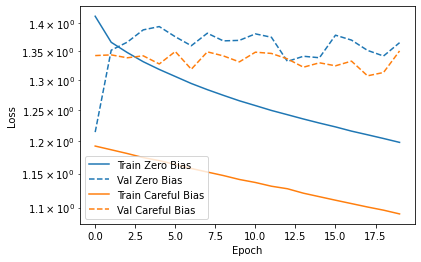

In [6]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [7]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        
        plt.legend()

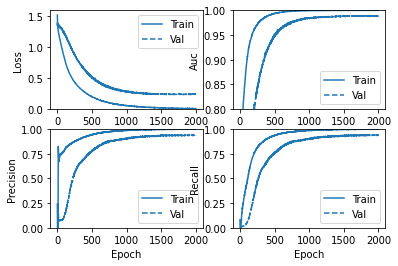

In [8]:
import shutil
import time
try:
    shutil.rmtree('Graph/')
    time.sleep(1.2)
except:
    pass

if cfg.compute_weight_ratios:
    model = make_model(output_bias=initial_bias)
else:
    model = make_model()
# model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    to_categorical(train_labels),
    batch_size=cfg.batch_size,
    epochs=cfg.epochs,
    verbose=0,
    callbacks = [tensorboard_callback, early_stopping],
    validation_data=(val_features, to_categorical(val_labels)))
plot_metrics(baseline_history)

In [9]:
train_predictions_baseline = model.predict(train_features, batch_size=cfg.batch_size)
test_predictions_baseline = model.predict(test_features, batch_size=cfg.batch_size)

In [10]:
test_predictions_baseline

array([[9.9994099e-01, 2.6576890e-06, 4.6581194e-05, 9.7162510e-06],
       [9.9997759e-01, 9.6450049e-07, 1.6814347e-05, 4.6042101e-06],
       [9.9993658e-01, 1.0912346e-05, 5.1488663e-05, 1.0046623e-06],
       ...,
       [9.9999654e-01, 2.4550538e-06, 6.3974193e-07, 3.8781519e-07],
       [9.9994397e-01, 5.4271517e-05, 1.0046457e-06, 7.8390809e-07],
       [9.9989200e-01, 1.0206695e-04, 9.5881418e-08, 5.8083133e-06]],
      dtype=float32)

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Multi-Class Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.16950832497665072
tp :  1211.0
fp :  73.0
tn :  3779.0
fn :  73.0
accuracy :  0.9431464
precision :  0.9431464
recall :  0.9431464
auc :  0.9934769
mse :  0.022328213
rmse :  0.14942627
categorical_hinge :  0.12786055



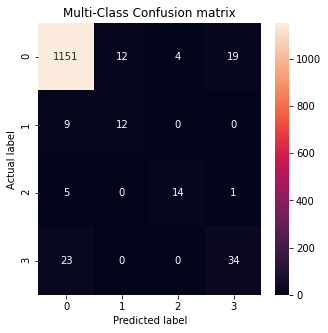

In [12]:
baseline_results = model.evaluate(test_features, to_categorical(test_labels),
                                  batch_size=cfg.batch_size, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline.argmax(axis=1))

In [13]:
# cfg['augment']['SMOTE'] = {'sampling_strategy': {1: .4, 2: .4, 3: .4}

In [14]:
test_predictions_baseline.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
import sklearn

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [16]:
# plot_roc("Train Baseline", train_labels, train_predictions_baseline.argmax(axis=1), color=colors[0])
# plot_roc("Test Baseline", test_labels, test_predictions_baseline.argmax(axis=1), color=colors[0], linestyle='--')
# plt.legend(loc='lower right')

In [17]:
# weighted_model = make_model()
# weighted_model.load_weights(initial_weights)
#
# weighted_history = weighted_model.fit(
#     train_features,
#     to_categorical(train_labels),
#     batch_size=cfg.batch_size,
#     epochs=cfg.epochs,
#     callbacks = [early_stopping],
#     validation_data=(val_features, to_categorical(val_labels)),
#     # The class weights go here
#     class_weight=ratios,
#     verbose=0)
#
# plot_metrics(weighted_history)
#
# baseline_results = weighted_model.evaluate(test_features, to_categorical(test_labels),
#                                   batch_size=cfg.batch_size, verbose=0)
# for name, value in zip(model.metrics_names, baseline_results):
#     print(name, ': ', value)
# print()
#
# plot_cm(test_labels, test_predictions_baseline.argmax(axis=1))
#
#
# to_categorical(test_predictions_baseline.argmax(axis=1)).argmax(axis=1)
#
#
# test_predictions_baseline.argmax(axis=1)